# Curso IML1 - Unidade 2 - Classificação

Análise do conjunto de dados da [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)

Livro: **Aprendizado de máquina: uma abordagem estatística** (http://www.rizbicki.ufscar.br/ame/)

# Upload do conjunto de dados

O conjunto de dados utilizados para demonstração dos métodos é uma amostra do [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews).

Para abrir o arquivo, precisamos fazer o upload para o Driver.

In [1]:
#%pip install pandas==2.0.3
#%pip install scikit_learn==1.3.2
#%pip install matplotlib==3.7.5
#%pip install xgboost==2.1.1
#%pip install tensorflow==2.13.0
#%pip install tensorflow
#%pip install nltk==3.8.1
#%pip install plotly==5.23.0
#%pip install nbformat>=4.2.0
#%pip install catboost
#%pip install lime
#%pip install lightgbm==4.5.0
#%pip install imblearn

In [2]:
# o código abaixa conecta o ambiente em execução com o Google Driver
#from google.colab import drive
#drive.mount('/content/drive')
#
import warnings
warnings.filterwarnings('ignore')

Selecione **Arquivos** no meu lateral esquerdo e clique em **Fazer upload para armazenamento da sessão**.

Driver.png

Selecione o arquivo **Reviews.csv** na sua máquina.

# Bibliotecas

In [3]:
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler

# modelos
from sklearn import linear_model, ensemble
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import class_weight

# selecao modelos
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import brier_score_loss as brier
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics  import RocCurveDisplay, PrecisionRecallDisplay
import lime
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Funções

# Ler e processar dados

Os dados abrangem um período de mais de 10 anos, incluindo todas as aproximadamente 500.000 análises até outubro de 2012. As análises incluem informações sobre produtos e usuários, classificações e uma análise em texto simples. Também inclui avaliações de todas as outras categorias da Amazon.

In [4]:
# abrindo arquivo
data = pd.read_csv("./Reviews.csv", nrows=10_000)

y = data['Score'].copy()
X = data['Text'].copy()

# frequencia da variavel dependente
y.value_counts().plot(kind = 'barh')

<Axes: >

Nosso objetivo é estimar se o score é alto ou baixo com base no comentário feito. Portanto, vamos utilizar a coluna **Text** para criar as covariáveis e vamos transformar a coluna **Score** em binária.

## Tratando os dados

Nosso conjunto de treino são os textos dos reviews feitos. Para conseguir utilizar o modelos de ML, precisamos transformar nosso dados em uma matriz de números. Utilizaremos a técnica Bag of Words para criar uma matriz de contagens de palavras.

Etapas que serão aplicadas:
*   Removendo números
*   Passando o texto para minúsculo
*   Dividindo em treino e teste
*   Transformando em matriz de contagens (Bag of Words)


In [5]:
X.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [6]:
# Removendo numeros e passando para minusculo
X = (
    X
    .str.replace(r'[^\w\s]|[\d]', '', regex = True)
    .str.lower()
    )

X.head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price  there was a wide...
Name: Text, dtype: object

In [7]:
# dividindo em treino e teste
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size = 1/10, random_state = 0)

In [8]:
# transformando em matriz de contagens
class LemmaTokenizer(object):
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, articles):
    return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
    

# a palavras serão criadas a partir dos dados de treino
cv = CountVectorizer(
  tokenizer=LemmaTokenizer(), max_features=1_500, stop_words='english',
  token_pattern=r'(?u)\b\w\w\w+\b', min_df=0.005, binary=True)
X_train = cv.fit_transform(X_train)
# aplicando nos dados de teste
X_test = cv.transform(X_test)
# palabras utilizadas
features = cv.get_feature_names_out()


print(f"Dimensão do conjunto de treino: {X_train.shape}")
X_train.toarray()

Dimensão do conjunto de treino: (9000, 972)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
del data
del X
del y

## Classificação Binária

In [11]:
y_train=(Y_train>3).astype(int)
y_test=(Y_test>3).astype(int)

In [12]:
X_train_df = pd.DataFrame(X_train.toarray(), columns=features)
X_test_df  = pd.DataFrame(X_test.toarray(), columns=features)

In [13]:
classes_weights = list(class_weight.compute_class_weight(
  class_weight ='balanced', classes=np.unique(y_train), y=y_train
))

weights = [classes_weights[i] for i in y_train]

## Exemplo: Classes desbalanceadas

In [14]:
y_train.value_counts(normalize = True)*100

1    76.222222
0    23.777778
Name: Score, dtype: float64

Acurácia = 0.853
F1 = 0.9079524107701941


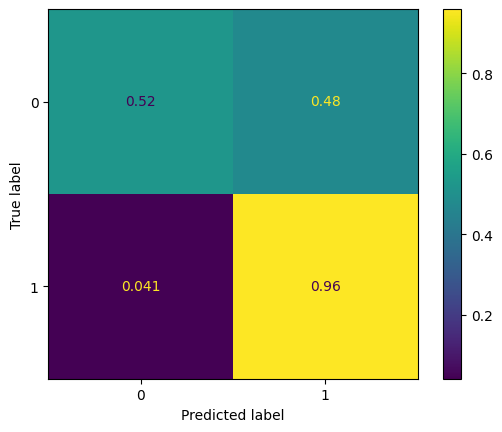

In [15]:
logistica_l1 = linear_model.LogisticRegressionCV(
  penalty="l1",solver='liblinear',scoring='neg_log_loss', max_iter=100, 
).fit(X=X_train,y=y_train)
# plot confunsion matriz
y_pred = logistica_l1.predict(X_test)
print(f"Acurácia = {acc(y_test,y_pred)}")
print(f"F1 = {metrics.f1_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_estimator(logistica_l1, X_test, y_test, normalize = 'true')

In [16]:
logistica_l1 = linear_model.LogisticRegressionCV(
  penalty="l1",solver='liblinear',scoring='neg_log_loss', max_iter=100,
  class_weight='balanced'
).fit(X=X_train,y=y_train)
# plot confunsion matriz
y_pred = logistica_l1.predict(X_test)
print(f"Acurácia = {acc(y_test,y_pred)}")
print(f"F1 = {metrics.f1_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_estimator(logistica_l1, X_test, y_test, normalize = 'true')

Acurácia = 0.831
F1 = 0.884641638225256


# Seleção de Modelos

## Funções

In [17]:
models = {}

def plot_roc_curve_threshold(y_true, y_pred_proba):
  fpr, tpr, thresholds = metrics.roc_curve(y_true,  y_pred_proba)
  auc = metrics.roc_auc_score(y_true, y_pred_proba)

  roc = pd.DataFrame({
    'fpr' : fpr,
    'tpr' : tpr,
    'tf' : tpr - (1-fpr),
    'thresholds' : thresholds
  })

  plt.plot(roc['fpr'],roc['tpr'],label="auc="+str(auc))
  plt.plot( [0,1], [0,1], '--r')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # optimal threshold
  point = roc.iloc[(roc.tf-0).abs().argsort()[0]]
  plt.scatter(
    point['fpr'], point['tpr'], color = 'purple', s = 50,
    label = f"optimal threshold  = {point['thresholds'].round(2)}"
  )

  # .5 threshold
  point = roc.iloc[(roc.thresholds-0.5).abs().argsort()[:1][0]]
  plt.scatter(
    point['fpr'], point['tpr'], color = 'orange', s = 50,
    label = 'threshold = 0.50'
  )


  plt.legend()
  plt.show()

def plot_models_roc_curve(models, X_test, y_test):
  models = list(models.values())
  plot_ax = RocCurveDisplay.from_estimator(models[0], X_test, y_test)
  for i in range(1, len(models)):
    RocCurveDisplay.from_estimator(models[i], X_test, y_test, ax=plot_ax.ax_)
  plt.show()

def plot_roc_curve(models, X_test, y_test):
  print('Curva ROC ', list(models.keys())[-1])
  plot_roc_curve_threshold(y_true=y_test, y_pred_proba=list(models.values())[-1].predict_proba(X_test)[:,1])
  print('Comparação de modelos')
  plot_models_roc_curve(models, X_test, y_test)


# função que plota os n maiores coeficientes positivos e negativos
def plot_coefs(coefs, n):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  coefs.nsmallest(n, 'coef').query('coef < 0').sort_values('coef', ascending = False).plot(kind = 'barh', x = 'features', y = 'coef', color = 'red',  title = 'Coeficientes Negativos', legend=False, ax=ax1)
  coefs.nlargest(n, 'coef').query('coef >= 0').sort_values('coef', ascending = True).plot(kind = 'barh', x = 'features', y = 'coef', color = 'blue', title = 'Coeficientes Possitivos', legend=False, ax=ax2, xlabel = "")
  fig.tight_layout()

In [18]:
resultados = pd.DataFrame(columns = ['Method','Acurácia', 'Precisão', "Recall",'F1','Log-loss'])

def get_model_metrics(model_name, threshold, y_prob, y_test):
  # salvando resultado
  y_pred = (y_prob > threshold)*1
  acc_estimate = round(acc(y_test,y_pred), 3)
  log_estimate = round(log_loss(y_test,y_prob), 3)
  precision = round(precision_score(y_test, y_pred), 3)
  recall = round(recall_score(y_test, y_pred), 3)
  f1_score = round(metrics.f1_score(y_test, y_pred), 3)
  
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'all')
  plt.show()

  return pd.DataFrame({
    'Method': [model_name],
    'Acurácia': [acc_estimate],
    "Precisão": [precision],
    "Recall": [recall],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
})

## Logística

### Sem Penalização

In [19]:
models['Logistica sem penalização'] = linear_model.LogisticRegression(
  penalty = None, max_iter=1000
).fit(X = X_train,y = y_train)

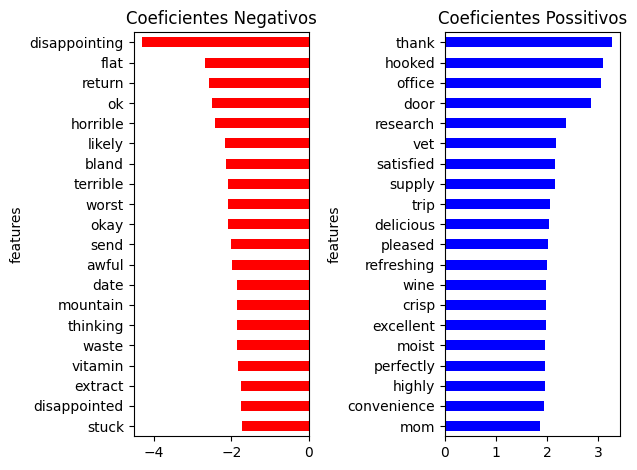

In [20]:
# plotando maiores coeficientes
plot_coefs(
  coefs = pd.DataFrame({
    'features':features,
    'coef':models['Logistica sem penalização'].coef_[0]
  }),
  n = 20
)

Curva ROC  Logistica sem penalização


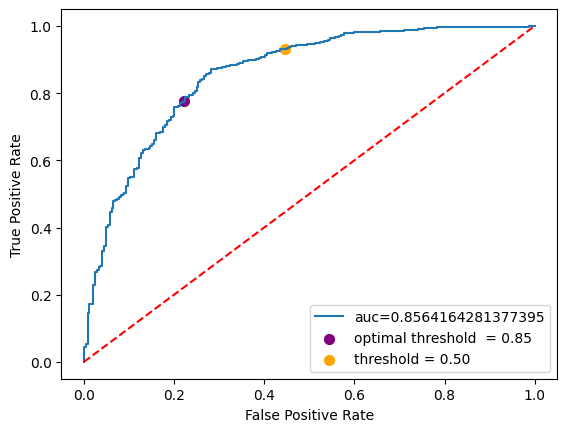

Comparação de modelos


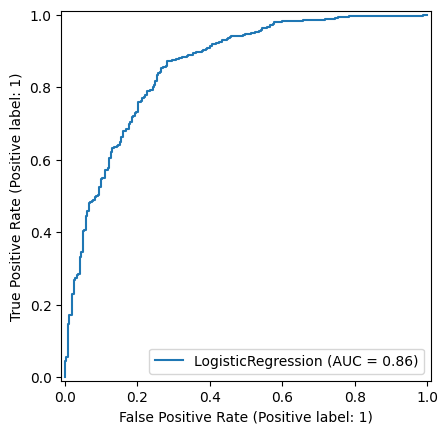

In [21]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

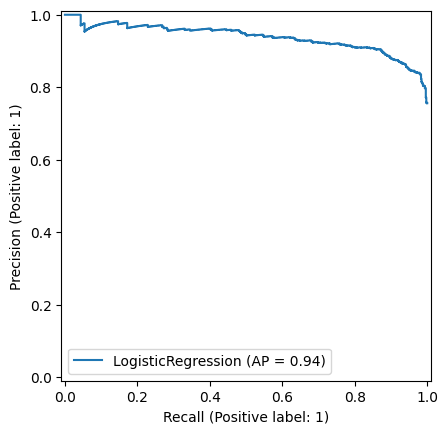

In [22]:
PrecisionRecallDisplay.from_estimator(models['Logistica sem penalização'], X_test, y_test)

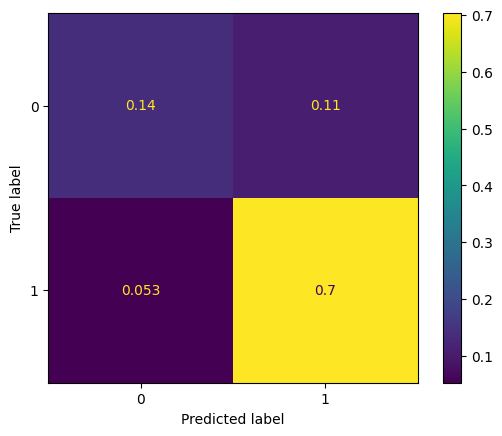

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização      0.84     0.868    0.93  0.898     0.443

In [23]:
resultado_modelo = get_model_metrics(
  model_name='Logistica sem penalização',
  threshold=.5,
  y_prob=models['Logistica sem penalização'].predict_proba(X_test)[:,1],
  y_test=y_test)

resultados = pd.concat([resultados, resultado_modelo])
resultados

### Com penalização

In [24]:
models['Logistica penalização L1'] = linear_model.LogisticRegressionCV(
  penalty="l1",solver='liblinear',scoring='neg_log_loss',
  max_iter=100, cv = 10
).fit(X=X_train,y=y_train)

In [25]:
print(f"total de variaveis com coeficientes 0 = {sum(models['Logistica penalização L1'].coef_[0]==0)}")
print(f"total de variaveis = {len(models['Logistica penalização L1'].coef_[0])}")

total de variaveis com coeficientes 0 = 426
total de variaveis = 972


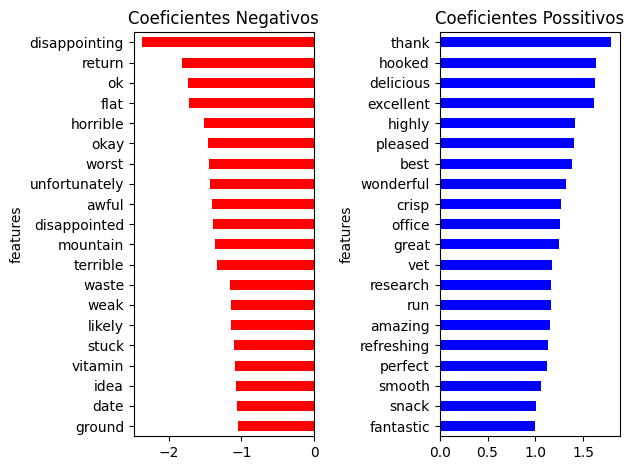

In [26]:
# plotando maiores coeficientes
plot_coefs(
  coefs = pd.DataFrame({
    'features':features,
    'coef':logistica_l1.coef_[0]
  }),
  n = 20
)

Curva ROC  Logistica penalização L1


Comparação de modelos


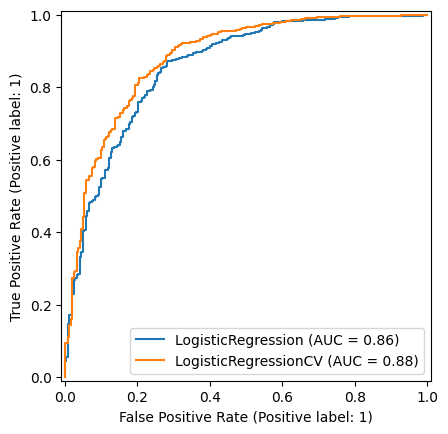

In [27]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

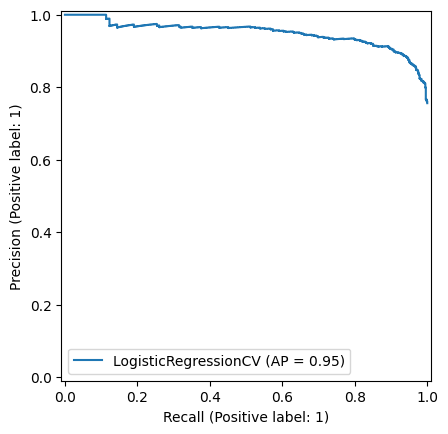

In [28]:
PrecisionRecallDisplay.from_estimator(logistica_l1, X_test, y_test)

In [29]:
resultado_modelo = get_model_metrics(
  model_name='Logistica penalização L1',
  threshold=.77,
  y_prob=models['Logistica penalização L1'].predict_proba(X_test)[:,1],
  y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352

## Árvores de Decisão

In [30]:
models['Arvore'] = DecisionTreeClassifier(random_state = 0)

# otimização de hiperparametros
param_grid = {'max_depth':np.arange(1, 20)}
arvore_gscv = GridSearchCV(models['Arvore'], param_grid, cv = 10, scoring='neg_log_loss')
arvore_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {arvore_gscv.best_params_}")

plt.figure()
plt.plot(arvore_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# utilizando o melhores parametros
models['Arvore'].set_params(**arvore_gscv.best_params_)
models['Arvore'].fit(X_train,y_train)

Melhores Parametros: {'max_depth': 3}


DecisionTreeClassifier(max_depth=3, random_state=0)

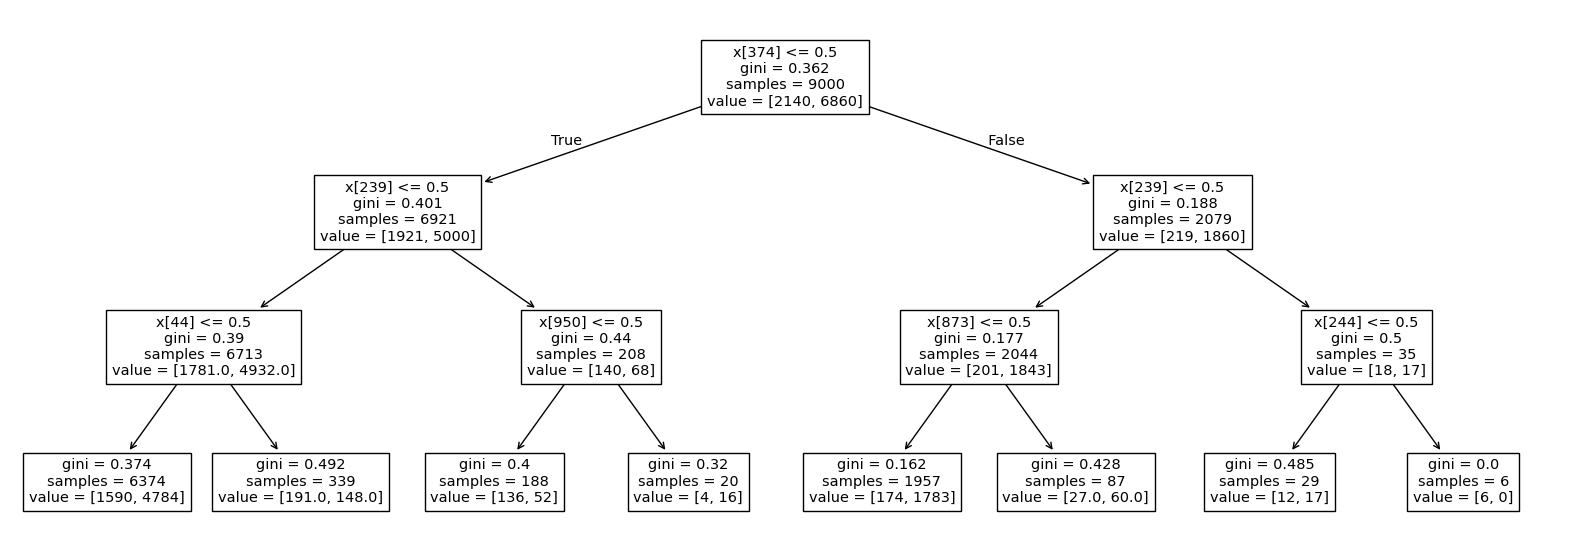

In [31]:
# plotando arvore de decisão
plt.rcParams['figure.figsize'] = [20, 7]
plot_tree(models['Arvore'])
plt.show()

In [32]:
plt.rcParams['figure.figsize'] = [5, 5]

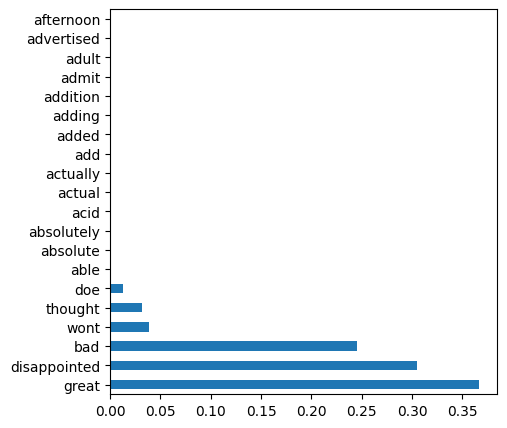

In [33]:
# plotando as variaveis mais importantes
feat_importances = pd.Series(
  models['Arvore'].feature_importances_,
  index= features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [34]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

Curva ROC  Arvore


Comparação de modelos


In [35]:
resultado_modelo = get_model_metrics(
  model_name='Arvore',
  threshold=.82,
  y_prob=models['Arvore'].predict_proba(X_test)[:,1],
  y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531

## Florestas

Melhores Parametros: {'max_depth': 90, 'max_features': 'sqrt'}


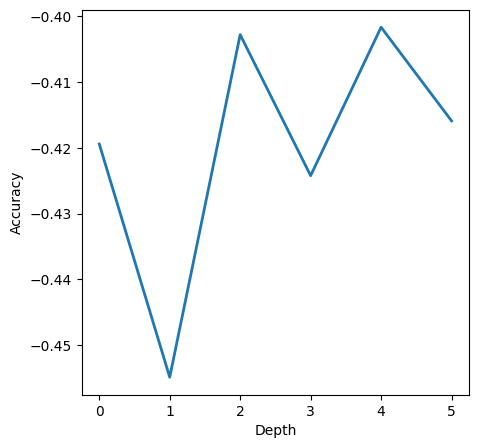

RandomForestClassifier(max_depth=90, n_estimators=400, random_state=0)

In [36]:
models['Florestas'] = RandomForestClassifier(random_state = 0, n_estimators = 400)

# otimização de hiperparametros
param_grid = {
    'max_depth': [30, 60, 90],
    'max_features': ['sqrt', 'log2']
    }
floresta_gscv = GridSearchCV(models['Florestas'], param_grid, cv=2,scoring='neg_log_loss')
floresta_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {floresta_gscv.best_params_}")

plt.figure()
plt.plot(floresta_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# utilizando o melhores parametros
models['Florestas'].set_params(**floresta_gscv.best_params_)
models['Florestas'].fit(X_train,y_train)

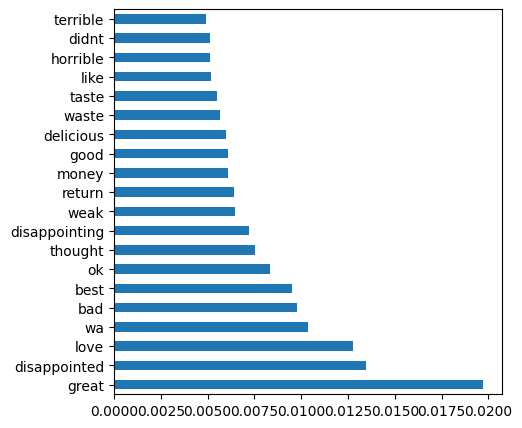

In [37]:
# plotando as variaveis mais importantes
feat_importances = pd.Series(
    models['Florestas'].feature_importances_,
    index= features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Curva ROC  Florestas


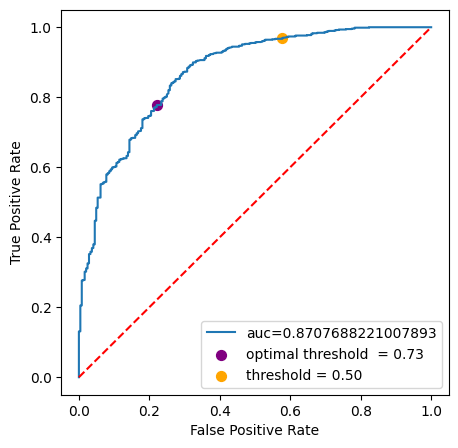

Comparação de modelos


In [38]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

In [39]:
resultado_modelo = get_model_metrics(
    model_name='Florestas',
    threshold=.74,
    y_prob=models['Florestas'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381

## XGBoost

In [40]:
models['XGBoost'] = xgb.XGBClassifier(eval_metric=["logloss"], early_stopping_rounds=10,)

# otimização de hiperparametro
parameters = {'max_depth': [3,7,15,30],
              'min_child_weight': [2,5],
              'subsample': [0.8,1],
              'colsample_bytree': [0.75,1],
              'n_estimators': [350, 500],
              'eta':[0.5,1]}

X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=7)
xgb_classes_weights = list(class_weight.compute_class_weight(
    class_weight ='balanced', classes=np.unique(y_train_1), y=y_train_1
    ))
xgb_weights = [xgb_classes_weights[i] for i in y_train_1]
eval_set = [(X_train_1,y_train_1),(X_val, y_val)]

xgb_model_gscv = GridSearchCV(models['XGBoost'], parameters, n_jobs=4, cv=2,scoring='neg_log_loss')
xgb_model_gscv.fit(
    X_train_1, y_train_1,
    eval_set=eval_set,
    sample_weight=xgb_weights)

results = xgb_model_gscv.best_estimator_.evals_result()

models['XGBoost'].set_params(**xgb_model_gscv.best_params_)
models['XGBoost'].fit(
    X_train_1, y_train_1,
    eval_set=eval_set, sample_weight=xgb_weights)

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

[0]	validation_0-logloss:0.55971	validation_1-logloss:0.59327
[1]	validation_0-logloss:0.49304	validation_1-logloss:0.55162
[2]	validation_0-logloss:0.44948	validation_1-logloss:0.51953
[3]	validation_0-logloss:0.42199	validation_1-logloss:0.49774
[4]	validation_0-logloss:0.39368	validation_1-logloss:0.47911
[5]	validation_0-logloss:0.37253	validation_1-logloss:0.46825
[6]	validation_0-logloss:0.34906	validation_1-logloss:0.45965
[7]	validation_0-logloss:0.33634	validation_1-logloss:0.45049
[8]	validation_0-logloss:0.32336	validation_1-logloss:0.44496
[9]	validation_0-logloss:0.31052	validation_1-logloss:0.44003
[10]	validation_0-logloss:0.29999	validation_1-logloss:0.43365
[11]	validation_0-logloss:0.28898	validation_1-logloss:0.43005
[12]	validation_0-logloss:0.28276	validation_1-logloss:0.42766
[13]	validation_0-logloss:0.27644	validation_1-logloss:0.42361
[14]	validation_0-logloss:0.26793	validation_1-logloss:0.41755
[15]	validation_0-logloss:0.25996	validation_1-logloss:0.41663
[1

Curva ROC  XGBoost


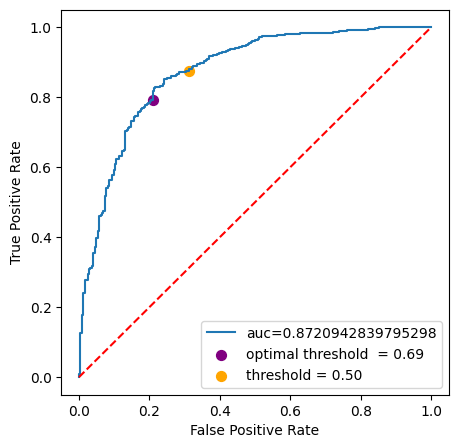

Comparação de modelos


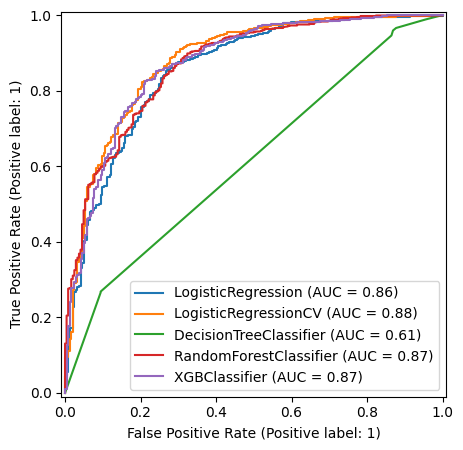

In [41]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

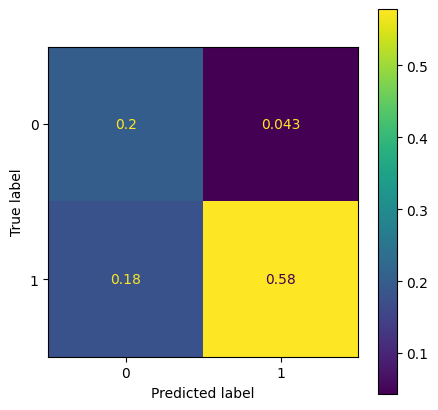

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381

In [42]:
resultado_modelo = get_model_metrics(
    model_name='XGBoost',
    threshold=.73,
    y_prob=models['XGBoost'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## LightGBM

In [43]:
models['LightGBM'] = lgb.LGBMClassifier()

# otimização de hiperparametros
params_grid = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'],
                'objective': ['binary'],
                'colsample_bytree': [0.65, 0.75, 0.8],
                'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                'reg_lambda': [1, 2, 6]}

lgb_rscv = GridSearchCV(models['LightGBM'], params_grid, cv=2,scoring='neg_log_loss')
lgb_rscv.fit(X_train, y_train,sample_weight=weights)

# resultado
print(f"Melhor Pontuação: {lgb_rscv.best_score_}")
print(f"Melhores Parametros: {lgb_rscv.best_params_}")

# utilizando o melhores parametros
models['LightGBM'].set_params(**lgb_rscv.best_params_)
models['LightGBM'].fit(X_train.astype('float32'),y_train,sample_weight=weights)

[LightGBM] [Info] Number of positive: 3430, number of negative: 1070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1916
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 958
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3430, number of negative: 1070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 952
[LightGBM] [Info] [bin

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, n_estimators=24,
               num_leaves=16, objective='binary', reg_alpha=1, reg_lambda=1,
               subsample=0.7)

Curva ROC  LightGBM


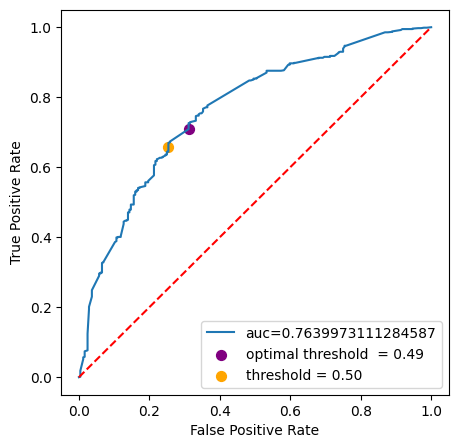

Comparação de modelos


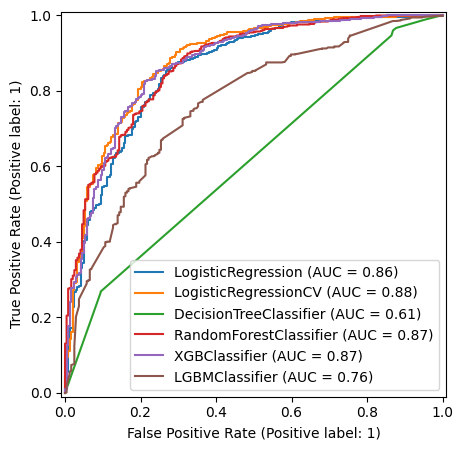

In [44]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

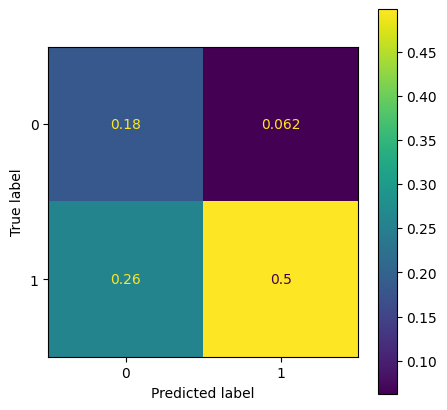

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660

In [45]:
resultado_modelo = get_model_metrics(
    model_name='LightGBM',
    threshold=.5,
    y_prob=models['LightGBM'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## CatBoost

In [46]:
models['CatBoost'] = CatBoostClassifier()

# otimização de hiperparametros
params_grid = [{
    'depth':[3,1,2,6,4,5,7,8,9,10],
    'iterations':[250,100,500,1000],
    'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
    'l2_leaf_reg':[3,1,5,10,100],
    'border_count':[32,5,10,20,50,100,200],
    #'ctr_border_count':[50,5,10,20,100,200],
    'thread_count':[4]
    }]
catb_rscv = RandomizedSearchCV(models['CatBoost'], params_grid, cv=2,scoring='accuracy', n_iter = 15)
catb_rscv.fit(X_train_df, y_train, sample_weight=weights)

# resultado
print(f"Melhor Pontuação: {catb_rscv.best_params_}")
print(f"Melhores Parametros: {catb_rscv.best_params_}")

# utilizando o melhores parametros
models['CatBoost'].set_params(**catb_rscv.best_params_)
models['CatBoost'].fit(X_train_df,y_train, sample_weight=weights)

0:	learn: 0.6755811	total: 463ms	remaining: 45.8s
1:	learn: 0.6635132	total: 812ms	remaining: 39.8s
2:	learn: 0.6511947	total: 1.06s	remaining: 34.4s
3:	learn: 0.6432582	total: 1.24s	remaining: 29.9s
4:	learn: 0.6332815	total: 1.41s	remaining: 26.7s
5:	learn: 0.6262062	total: 1.56s	remaining: 24.5s
6:	learn: 0.6171094	total: 1.71s	remaining: 22.7s
7:	learn: 0.6102087	total: 1.85s	remaining: 21.3s
8:	learn: 0.6048936	total: 2.03s	remaining: 20.6s
9:	learn: 0.5978152	total: 2.24s	remaining: 20.2s
10:	learn: 0.5922764	total: 2.54s	remaining: 20.5s
11:	learn: 0.5862849	total: 2.73s	remaining: 20s
12:	learn: 0.5814472	total: 2.97s	remaining: 19.9s
13:	learn: 0.5772846	total: 3.23s	remaining: 19.8s
14:	learn: 0.5723485	total: 3.45s	remaining: 19.6s
15:	learn: 0.5687222	total: 3.63s	remaining: 19s
16:	learn: 0.5638703	total: 3.81s	remaining: 18.6s
17:	learn: 0.5597662	total: 3.95s	remaining: 18s
18:	learn: 0.5549516	total: 4.13s	remaining: 17.6s
19:	learn: 0.5508542	total: 4.33s	remaining: 17

Curva ROC  CatBoost


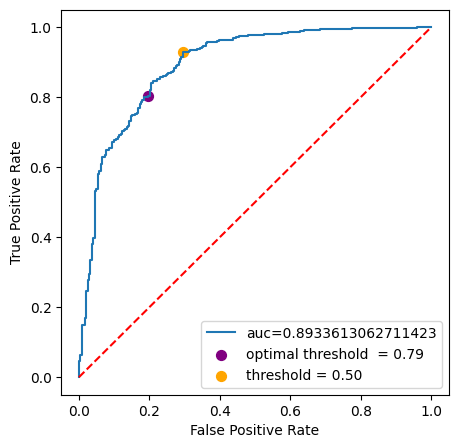

Comparação de modelos


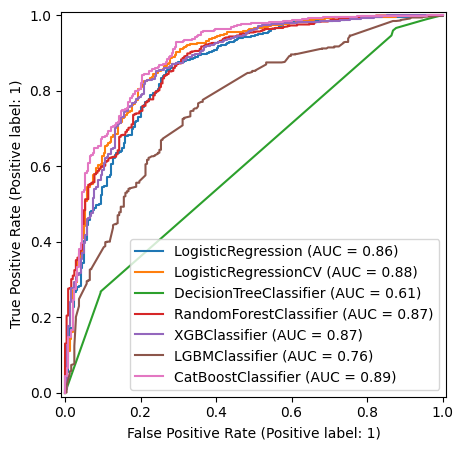

In [47]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

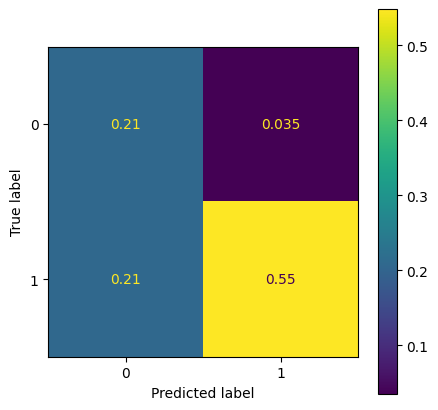

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367

In [48]:
resultado_modelo = get_model_metrics(
    model_name='CatBoost',
    threshold=.9,
    y_prob=models['CatBoost'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## KNN

### Com todas variáveis

In [49]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

Melhores Parametros: {'n_neighbors': 15}


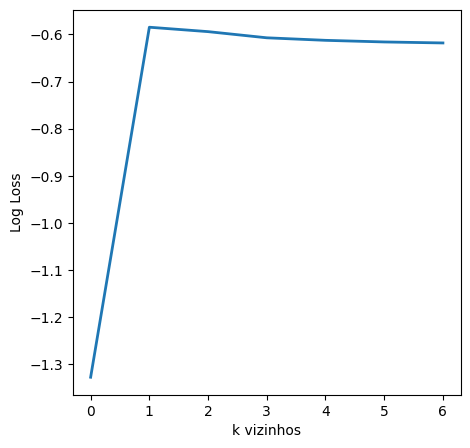

KNeighborsClassifier(n_neighbors=15)

In [50]:
# criando modelo
models['KNN'] = KNeighborsClassifier()

# otimização de hiperparametros
param_grid = {'n_neighbors': [5, 15, 25, 45, 65, 85, 100]}
knn_gscv = GridSearchCV(models['KNN'], param_grid, cv=2,scoring='neg_log_loss')
knn_gscv.fit(X_train_resampled, y_train_resampled)

# resultado
# resultado
print(f"Melhores Parametros: {knn_gscv.best_params_}")

plt.figure()
plt.plot(knn_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('k vizinhos')
plt.ylabel('Log Loss')
plt.show()

# utilizando o melhores parametros
models['KNN'].set_params(**knn_gscv.best_params_)
models['KNN'].fit(X_train,y_train)

Curva ROC  KNN


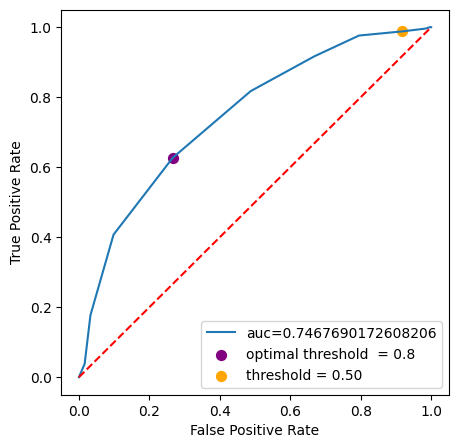

Comparação de modelos


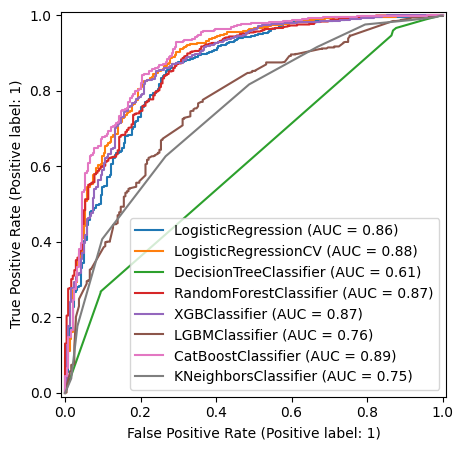

In [51]:
# ROC curve
plot_roc_curve(models, X_test, y_test)

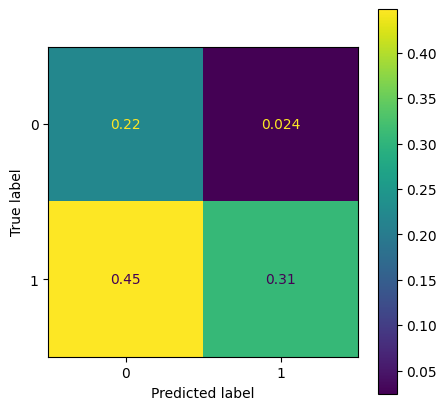

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616

In [52]:
resultado_modelo = get_model_metrics(
    model_name='KNN',
    threshold=.84,
    y_prob=models['KNN'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

### Com seleção de variáveis

In [53]:
from sklearn.feature_selection import RFECV
floresta_rfe = RFECV(
    models['Florestas'], min_features_to_select = 50,
    step = 0.3, verbose = 10, cv=2
    ).fit(X_train,y_train)

Fitting estimator with 972 features.
Fitting estimator with 681 features.
Fitting estimator with 390 features.
Fitting estimator with 99 features.
Fitting estimator with 972 features.
Fitting estimator with 681 features.
Fitting estimator with 390 features.
Fitting estimator with 99 features.


In [54]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train[:,floresta_rfe.support_], y_train)

Melhores Parametros: {'n_neighbors': 15}


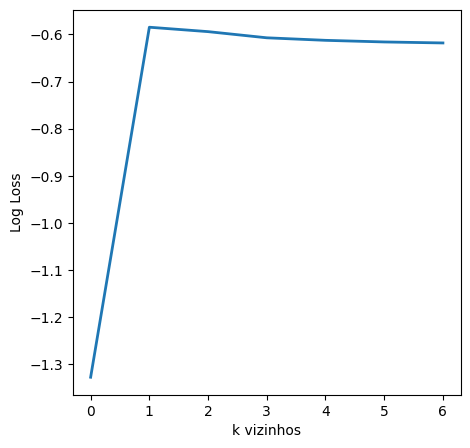

KNeighborsClassifier(n_neighbors=15)

In [55]:
# criando modelo
knn_rfe = KNeighborsClassifier()

# otimização de hiperparametros
param_grid = {'n_neighbors': [5, 15, 25, 45, 65, 85, 100]}
knn_gscv = GridSearchCV(knn_rfe, param_grid, cv=2,scoring='neg_log_loss')
knn_gscv.fit(X_train_resampled, y_train_resampled)

# resultado
# resultado
print(f"Melhores Parametros: {knn_gscv.best_params_}")

plt.figure()
plt.plot(knn_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('k vizinhos')
plt.ylabel('Log Loss')
plt.show()

# utilizando o melhores parametros
knn_rfe.set_params(**knn_gscv.best_params_)
knn_rfe.fit(X_train[:,floresta_rfe.support_],y_train)

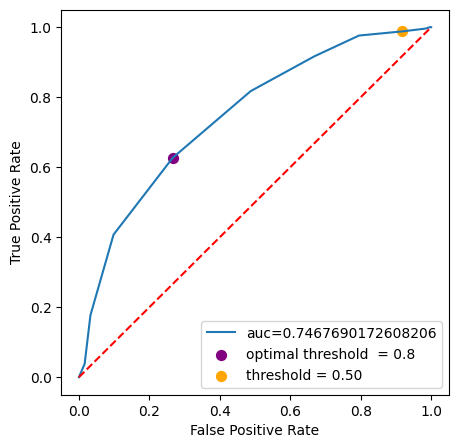

In [56]:
# ROC curve
plot_roc_curve_threshold(y_test, knn_rfe.predict_proba(X_test[:,floresta_rfe.support_])[:,1])

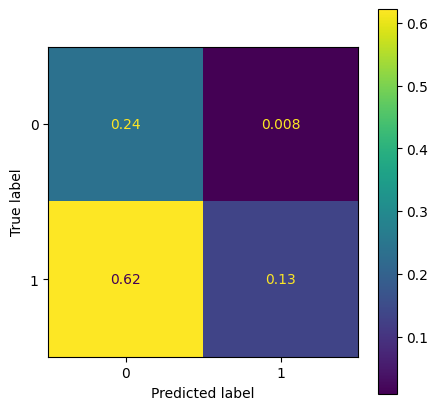

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616

In [57]:
resultado_modelo = get_model_metrics(
    model_name='KNN RFE',
    threshold=.87,
    y_prob=knn_rfe.predict_proba(X_test[:,floresta_rfe.support_])[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## Naive Bayes

In [58]:
models['NB'] = CategoricalNB().fit(X_train_df, y_train)

Curva ROC  NB


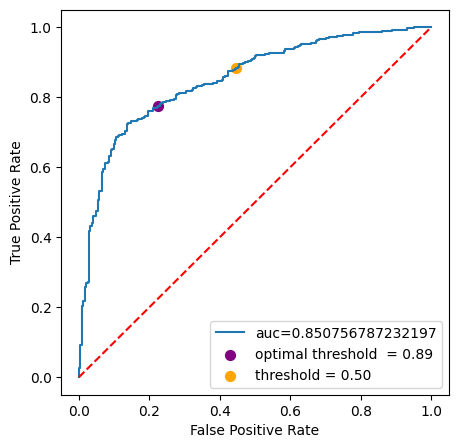

Comparação de modelos


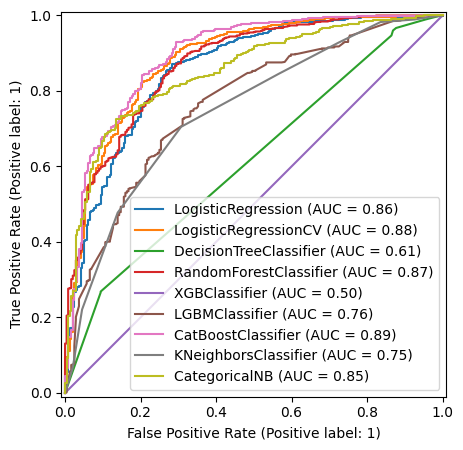

In [59]:
# ROC curve
plot_roc_curve(models, X_test_df, y_test)

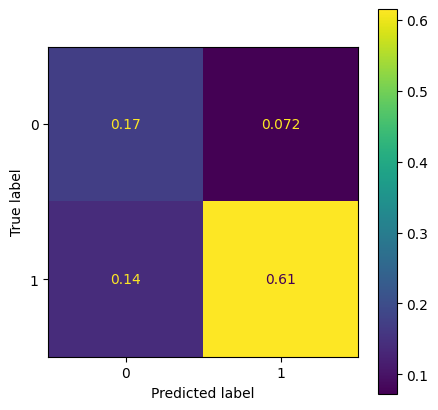

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613

In [60]:
resultado_modelo = get_model_metrics(
    model_name='Naive Bayes',
    threshold=.8,
    y_prob=models['NB'].predict_proba(X_test_df)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## Naive SVC

In [61]:
models['SVC'] = SVC(random_state = 0, probability=True, class_weight = 'balanced')

# otimização de hiperparametros
param_grid = [{'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly', 'sigmoid']}]
svc_gscv = GridSearchCV(models['SVC'], param_grid, cv=2,scoring='accuracy')
svc_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {svc_gscv.best_params_}")

# utilizando o melhores parametros
models['SVC'].set_params(**svc_gscv.best_params_)
models['SVC'].fit(X_train,y_train)

Melhores Parametros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


SVC(C=10, class_weight='balanced', gamma=0.01, probability=True, random_state=0)

Curva ROC  SVC


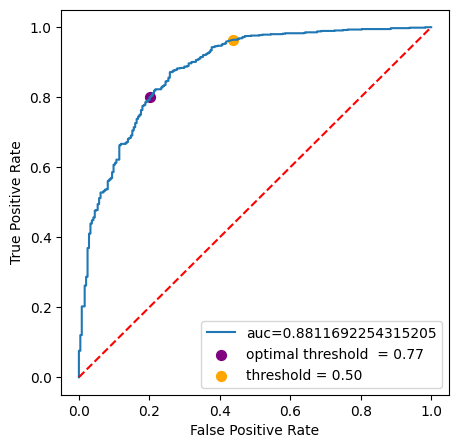

Comparação de modelos


In [62]:
# ROC curve
plot_roc_curve(models, X_test_df, y_test)

In [63]:
resultado_modelo = get_model_metrics(
    model_name='Naive SVC',
    threshold=.8,
    y_prob=models['SVC'].predict_proba(X_test)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613
0                  Naive SVC     0.777     0.931   0.762  0.838     0.351

## Nnets

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 30)             │        29,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,921 (116.88 KB)

 Trainable params: 29,921 (116.88 KB)

 Non-trainable params: 0 (0.00 B)

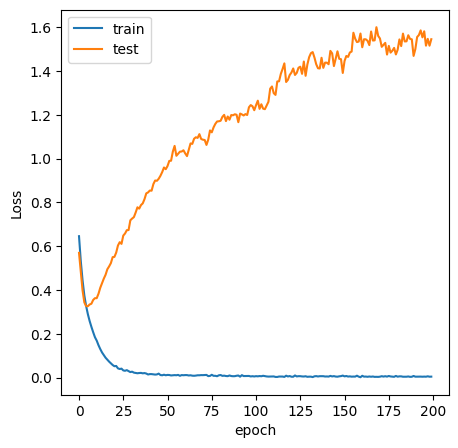

In [89]:
model = keras.Sequential(
    [
        keras.Input(shape=X_train_df.iloc[0].shape),
        layers.Dense(30, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(5, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

batch_size = 200
epochs = 200

metrics_score = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = metrics_score)

history = model.fit(
    X_train.toarray(), y_train,
    batch_size=batch_size, epochs=epochs,
    validation_split=0.1,shuffle=True,verbose=0)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


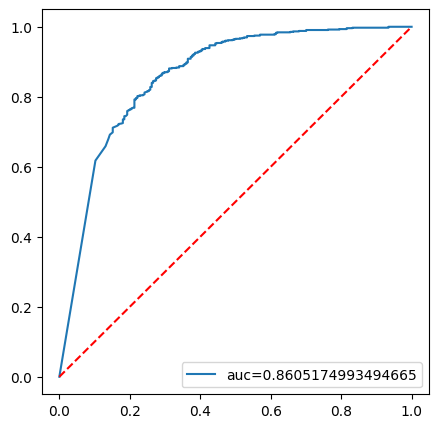

In [90]:
# plot confunsion matriz
y_pred_proba = model.predict(X_test.toarray())
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.plot( [0,1], [0,1], '--r')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


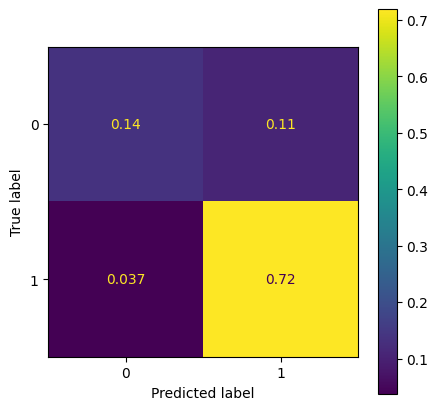

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613
0                  Naive SVC     0.777     0.931   0.762  0.838     0.351
0                     NNnets     0.850     0.880   0.929  0.903     1.380
0                     NNnets     0.855     0.869   0.951  0.908     1.462

In [91]:
resultado_modelo = get_model_metrics(
    model_name='NNnets',
    threshold=.5,
    y_prob=model.predict(X_test.toarray())[:,0],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## VotingClassifier

In [93]:
voting_models = ['Florestas', 'Logistica penalização L1', 'NB', 'SVC', 'CatBoost']

In [94]:
models['VotingClassifier'] = ensemble.VotingClassifier(estimators=[
          (model_name, models[model_name])
          for model_name in voting_models
          ], voting='soft'
        )
models['VotingClassifier'].fit(X_train_df,y_train)

0:	learn: 0.6210419	total: 64.3ms	remaining: 1m 4s
1:	learn: 0.5783751	total: 130ms	remaining: 1m 4s
2:	learn: 0.5448615	total: 200ms	remaining: 1m 6s
3:	learn: 0.5184071	total: 263ms	remaining: 1m 5s
4:	learn: 0.5028173	total: 338ms	remaining: 1m 7s
5:	learn: 0.4869383	total: 443ms	remaining: 1m 13s
6:	learn: 0.4760808	total: 524ms	remaining: 1m 14s
7:	learn: 0.4674825	total: 603ms	remaining: 1m 14s
8:	learn: 0.4596500	total: 692ms	remaining: 1m 16s
9:	learn: 0.4503605	total: 772ms	remaining: 1m 16s
10:	learn: 0.4461085	total: 850ms	remaining: 1m 16s
11:	learn: 0.4412637	total: 920ms	remaining: 1m 15s
12:	learn: 0.4357850	total: 988ms	remaining: 1m 15s
13:	learn: 0.4315667	total: 1.06s	remaining: 1m 14s
14:	learn: 0.4254226	total: 1.13s	remaining: 1m 14s
15:	learn: 0.4204366	total: 1.21s	remaining: 1m 14s
16:	learn: 0.4165537	total: 1.28s	remaining: 1m 14s
17:	learn: 0.4126147	total: 1.34s	remaining: 1m 13s
18:	learn: 0.4087636	total: 1.43s	remaining: 1m 13s
19:	learn: 0.4061924	total

VotingClassifier(estimators=[('Florestas',
                              RandomForestClassifier(max_depth=90,
                                                     n_estimators=400,
                                                     random_state=0)),
                             ('Logistica penalização L1',
                              LogisticRegressionCV(cv=10, penalty='l1',
                                                   scoring='neg_log_loss',
                                                   solver='liblinear')),
                             ('NB', CategoricalNB()),
                             ('SVC',
                              SVC(C=10, class_weight='balanced', gamma=0.01,
                                  probability=True, random_state=0)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x0000024F1E398E20>)],
                 voting='soft')

Curva ROC  VotingClassifier


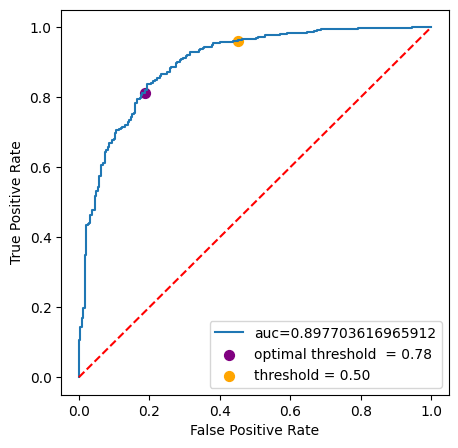

Comparação de modelos


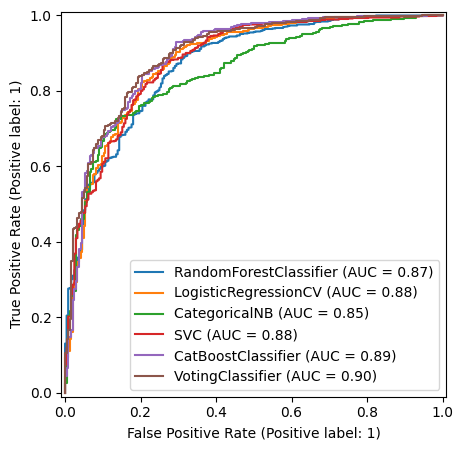

In [95]:
# ROC curve
plot_roc_curve({
    model_name: models[model_name]
    for model_name in voting_models + ['VotingClassifier']
    }, X_test_df, y_test)

In [96]:
resultado_modelo = get_model_metrics(
    model_name='VotingClassifier',
    threshold=.75,
    y_prob=models['VotingClassifier'].predict_proba(X_test_df)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613
0                  Naive SVC     0.777     0.931   0.762  0.838     0.351
0                     NNnets     0.850     0.880   0.929  0.903     1.380
0                     NNnets     0.855     0.869   0.951  0.908     1.462
0           VotingClassifier     0.831     0.926   0.844  0.883     0.332

## StackingClassifier

In [97]:
stacking_models = ['Florestas', 'Logistica penalização L1', 'NB', 'SVC', 'CatBoost']

In [98]:
models['StackingClassifier'] = ensemble.StackingClassifier(estimators=[
          (model_name, models[model_name])
          for model_name in stacking_models
          ]
        )
models['StackingClassifier'].fit(X_train_df,y_train)

0:	learn: 0.6210419	total: 75.3ms	remaining: 1m 15s
1:	learn: 0.5783751	total: 157ms	remaining: 1m 18s
2:	learn: 0.5448615	total: 242ms	remaining: 1m 20s
3:	learn: 0.5184071	total: 324ms	remaining: 1m 20s
4:	learn: 0.5028173	total: 408ms	remaining: 1m 21s
5:	learn: 0.4869383	total: 491ms	remaining: 1m 21s
6:	learn: 0.4760808	total: 575ms	remaining: 1m 21s
7:	learn: 0.4674825	total: 656ms	remaining: 1m 21s
8:	learn: 0.4596500	total: 732ms	remaining: 1m 20s
9:	learn: 0.4503605	total: 824ms	remaining: 1m 21s
10:	learn: 0.4461085	total: 897ms	remaining: 1m 20s
11:	learn: 0.4412637	total: 979ms	remaining: 1m 20s
12:	learn: 0.4357850	total: 1.05s	remaining: 1m 19s
13:	learn: 0.4315667	total: 1.12s	remaining: 1m 19s
14:	learn: 0.4254226	total: 1.18s	remaining: 1m 17s
15:	learn: 0.4204366	total: 1.24s	remaining: 1m 16s
16:	learn: 0.4165537	total: 1.31s	remaining: 1m 15s
17:	learn: 0.4126147	total: 1.38s	remaining: 1m 15s
18:	learn: 0.4087636	total: 1.44s	remaining: 1m 14s
19:	learn: 0.4061924	

StackingClassifier(estimators=[('Florestas',
                                RandomForestClassifier(max_depth=90,
                                                       n_estimators=400,
                                                       random_state=0)),
                               ('Logistica penalização L1',
                                LogisticRegressionCV(cv=10, penalty='l1',
                                                     scoring='neg_log_loss',
                                                     solver='liblinear')),
                               ('NB', CategoricalNB()),
                               ('SVC',
                                SVC(C=10, class_weight='balanced', gamma=0.01,
                                    probability=True, random_state=0)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000024F1E398E20>)])

In [99]:
# ROC curve
plot_roc_curve({
    model_name: models[model_name]
    for model_name in stacking_models + ['StackingClassifier']
    }, X_test_df, y_test)

Curva ROC  StackingClassifier


Comparação de modelos


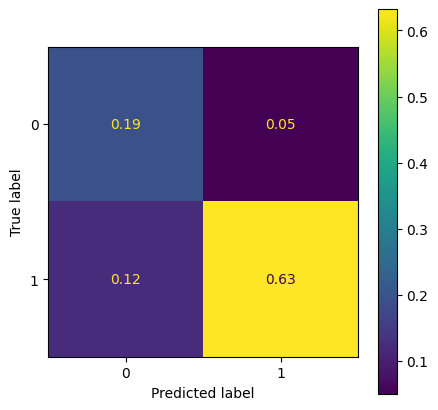

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613
0                  Naive SVC     0.777     0.931   0.762  0.838     0.351
0                     NNnets     0.850     0.880   0.929  0.903     1.380
0                     NNnets     0.855     0.869   0.951  0.908     1.462
0           VotingClassifier     0.831     0.926   0.844  0.883     0.332
0         StackingClassifier     0.826     0.927   0.836  0.879     0.327

In [100]:
resultado_modelo = get_model_metrics(
    model_name='StackingClassifier',
    threshold=.8,
    y_prob=models['StackingClassifier'].predict_proba(X_test_df)[:,1],
    y_test=y_test)
resultados = pd.concat([resultados, resultado_modelo])
resultados

## Resultados

In [101]:
resultados

Method  Acurácia  Precisão  Recall     F1  Log-loss
0  Logistica sem penalização     0.840     0.868   0.930  0.898     0.443
0   Logistica penalização L1     0.816     0.922   0.827  0.872     0.352
0                     Arvore     0.422     0.897   0.266  0.410     0.531
0                  Florestas     0.769     0.917   0.763  0.833     0.381
0                    XGBoost     0.779     0.931   0.765  0.840     0.381
0                   LightGBM     0.680     0.889   0.659  0.757     0.660
0                   CatBoost     0.757     0.940   0.725  0.819     0.367
0                        KNN     0.528     0.928   0.407  0.566     0.616
0                    KNN RFE     0.370     0.944   0.177  0.298     0.616
0                Naive Bayes     0.787     0.895   0.813  0.852     0.613
0                  Naive SVC     0.777     0.931   0.762  0.838     0.351
0                     NNnets     0.850     0.880   0.929  0.903     1.380
0                     NNnets     0.855     0.869   0.951  0.908     1.462
0           VotingClassifier     0.831     0.926   0.844  0.883     0.332
0         StackingClassifier     0.826     0.927   0.836  0.879     0.327

# Interpretação

## PDP

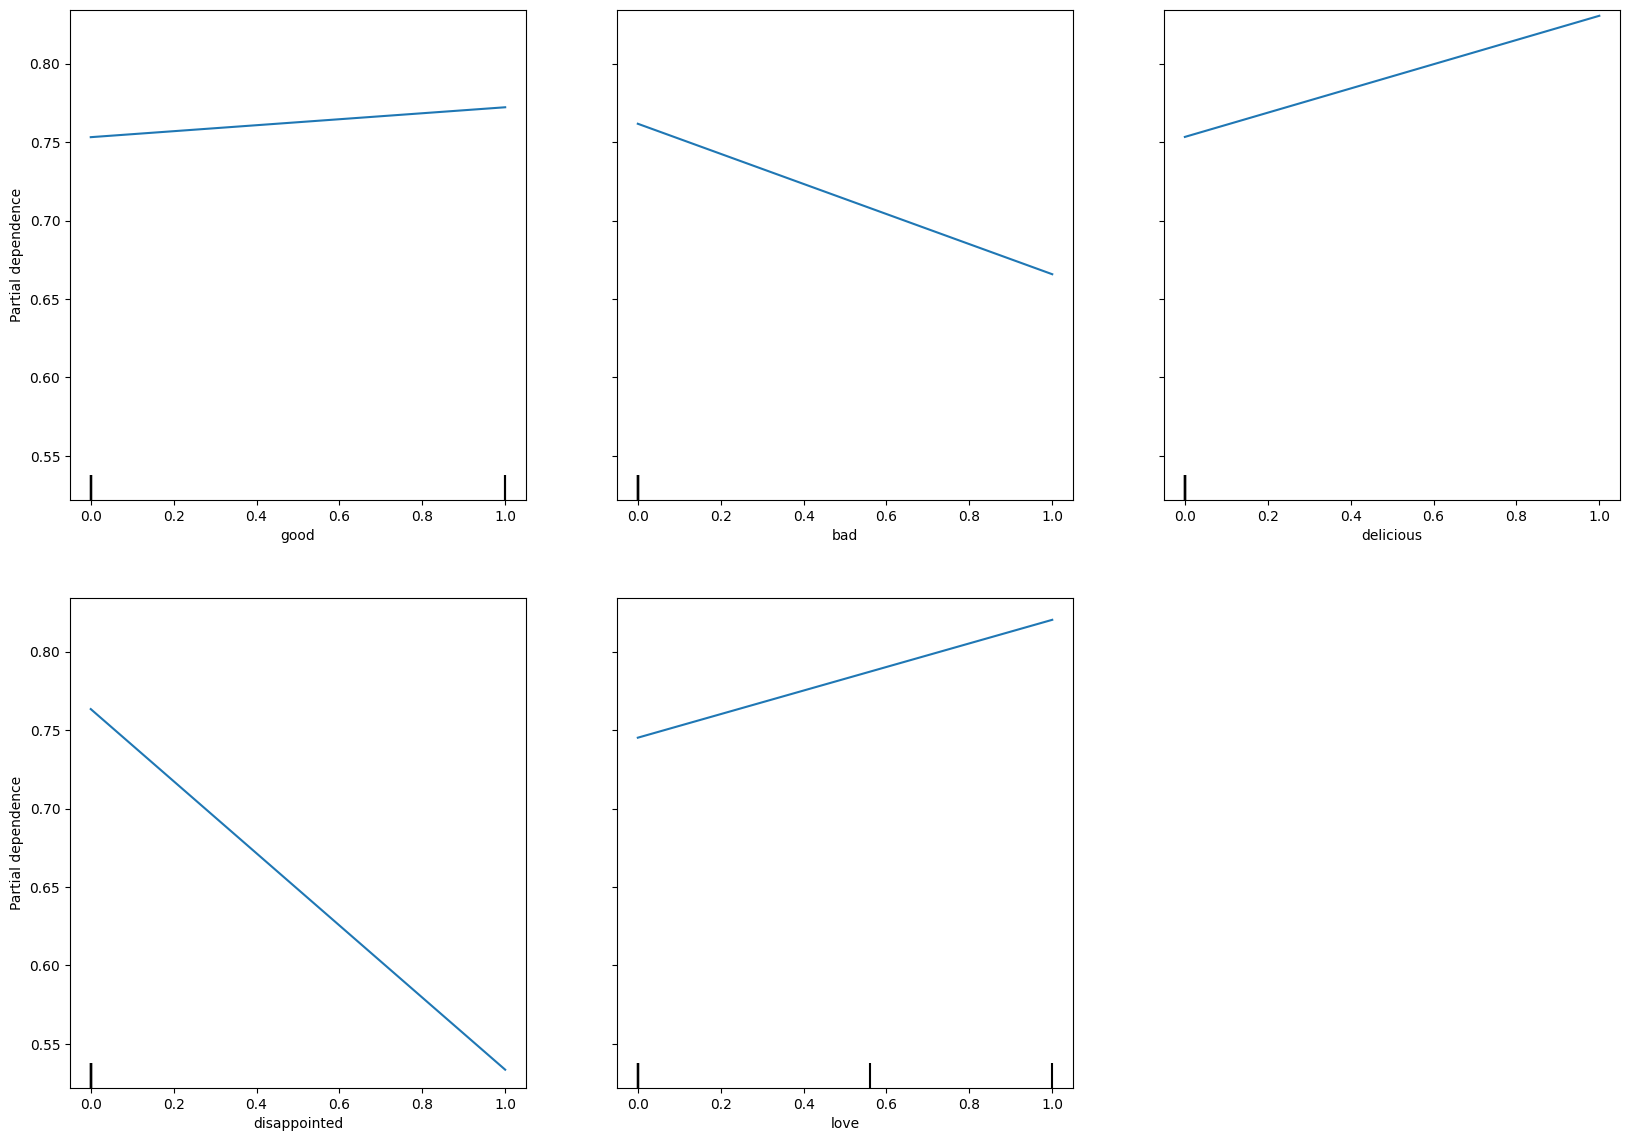

In [102]:
plt.rcParams['figure.figsize'] = [20, 14]

# plotando partial dependence
fig, ax = plt.subplots(figsize=(20, 14))
PartialDependenceDisplay.from_estimator(
    models['Florestas'], pd.DataFrame(X_test.toarray(), columns = features),
     ['good','bad', 'delicious',  'disappointed', 'love'], ax=ax)

plt.show()

In [103]:
plt.rcParams['figure.figsize'] = [10, 10]

## LIME

In [1]:
X_train

NameError: name 'X_train' is not defined

In [104]:
import lime.lime_tabular as lime_tabular
predict_ = lambda x: models['Logistica penalização L1'].predict_proba(x).astype(float)
explainer = lime_tabular.LimeTabularExplainer(
  X_train, mode="classification",
  feature_names = features,
  class_names=['Score Baixo','Score Alto']
)

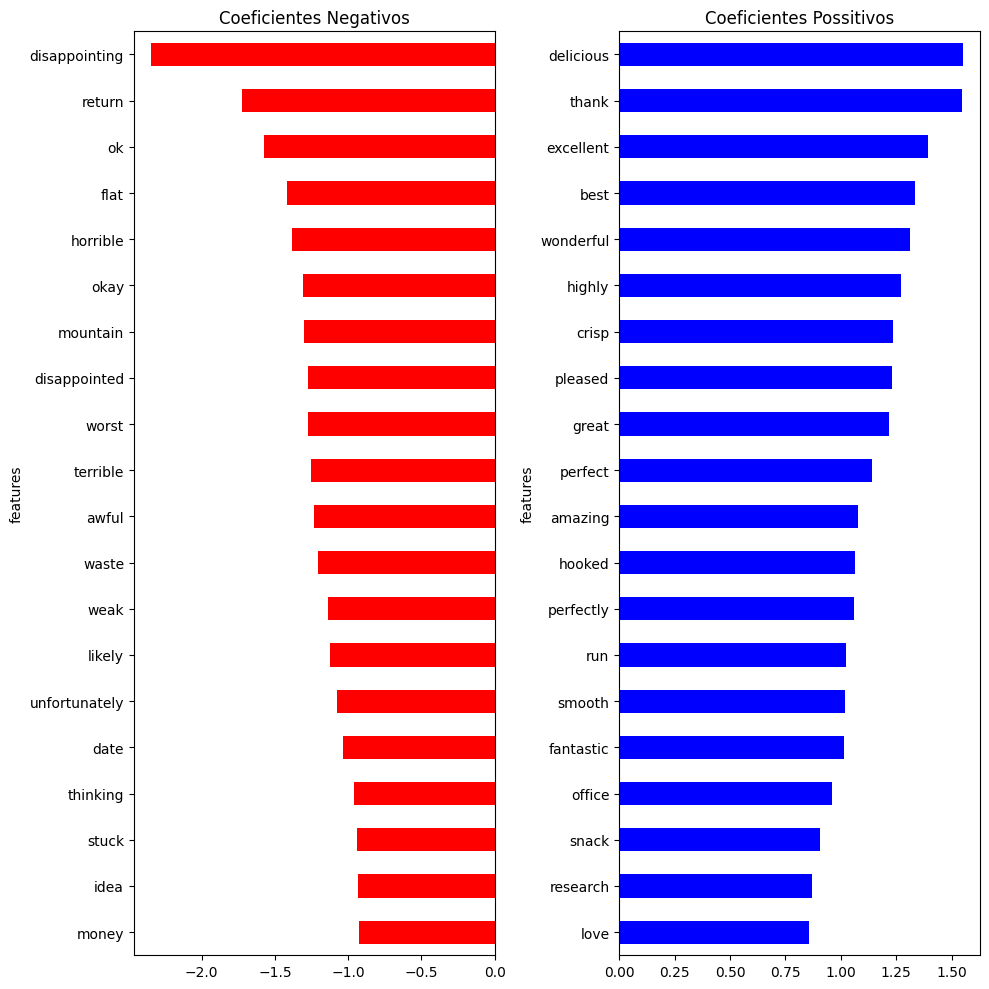

In [105]:
# plotando maiores coeficientes
plot_coefs(
    coefs = pd.DataFrame({
        'features':features,
        'coef':models['Logistica penalização L1'].coef_[0]
        }),
    n = 20
    )

In [106]:
choosen_instance = pd.DataFrame(X_test.toarray()).loc[[11]].values[0]

In [107]:
[word for word, bin in zip(features, pd.DataFrame(X_test.toarray()).loc[[11]].values[0]) if bin == 1]

['amazon',
 'cost',
 'diet',
 'double',
 'good',
 'great',
 'nearly',
 'pack',
 'popchips',
 'price',
 'snack']

In [108]:
exp = explainer.explain_instance(choosen_instance, predict_,  num_features=30)
exp.show_in_notebook(show_all=False)

In [109]:
exp.as_list()

[('great', 0.06006745912732459),
 ('best', 0.052774515566626094),
 ('delicious', 0.04551134795694373),
 ('love', 0.04514191440855952),
 ('excellent', 0.031636572005066345),
 ('good', 0.03032244822248614),
 ('wonderful', 0.030227700516702725),
 ('perfect', 0.02991915795900321),
 ('highly', 0.02910537898294135),
 ('favorite', 0.028456784621183402),
 ('smooth', 0.026055910155756104),
 ('snack', 0.02400393381600207),
 ('bad', -0.02388637896746731),
 ('disappointed', -0.023237371449272497),
 ('thought', -0.022016548653504317),
 ('nice', 0.02169549191124317),
 ('wa', -0.019945401612835225),
 ('use', 0.0182155264128665),
 ('year', 0.017983829265080516),
 ('taste', -0.01481819333398676),
 ('store', 0.01474906716861045),
 ('try', 0.01251836293526477),
 ('dont', -0.011873077858202914),
 ('product', -0.011250901073601273),
 ('amazon', 0.0059441095357837355),
 ('nearly', -0.004597396696926421),
 ('double', 0.0042620334658886655),
 ('pack', 0.0029681690395906256),
 ('price', 0.0005287107957764811),